In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import xgboost as xgb

from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

## CONSTANTS

# Define paths to excel files for reading data
DF_PATHS: list = ["../data/raw/ABSCHRIFTEN_20_Tagesbasis.xlsx",
                  "../data/raw/ABSCHRIFTEN_21_Tagesbasis.xlsx",
                  "../data/raw/ABSCHRIFTEN_22_Tagesbasis.xlsx"]

# Load Data

In [23]:
def clean_dataframe(path: str) -> pd.DataFrame:
    """
    Cleans data with some hardcoded rules.
    TBD: Change if data set are more clean / Talk to supervisors?

    :param path: str -- Path to excel file
    :return: pd.DataFrame -- Cleaned DataFrame
    """
    # Read in Data
    df = pd.read_excel(path)

    # Replace NaNs with 0
    df = df.replace({np.nan: 0})
    # Drop first column and other irrelevant rows
    df = df.drop(index=[0,1])
    # Drop aggregations
    df = df.drop(df.columns[2:4], axis=1)
    column_names = list(df.iloc[0, :])
    df.columns = column_names

    # Get GTIN as ID, remove first two entries
    GTIN = df.iloc[1, :]
    GTIN = GTIN[2:]
    GTIN = list(GTIN)
    GTIN.insert(0, "")

    # Keep only 'BACKWAREN BED' samples and drop the column then
    df = df[df.iloc[:,0] == "BACKWAREN BED"]
    df = df.iloc[:, 1:]
    # Rename time column
    df.rename(columns={df.columns[0]: "date" }, inplace = True)
    # Remove 'Ergebnis' row
    df = df[df["date"] != "Ergebnis"]

    # Reset index
    df = df.reset_index(drop=True)

    # Add GTIN to Names
    df.columns = [col + f"{gtin}" for col, gtin in zip(df.columns, GTIN)]

    # Put features in right data type
    df["date"] = pd.to_datetime(df["date"], dayfirst="True")

    numerical_columns = [col for col in df.columns if col != "date" ]
    df[numerical_columns] = df[numerical_columns].astype(np.float32)

    # Set date as index
    df.index = df.date
    df = df.drop(columns=["date"], axis=1)

    return df

# Initialize empty list to populate with processed dataframes (Abschriften)
abschriften: list[pd.DataFrame] = []
for path in DF_PATHS:
    abschriften_df = clean_dataframe(path)
    abschriften.append(abschriften_df)

# Preview df
df = abschriften[1] # ABSCHRIFTEN 2021
df

,MBK TEE NORMAL25004816,CAPPUCINO2064200170893,MBK QUARK-BUSSY 1 STUECK25006940,MBK MILCHKAFFEE KLEIN25007381,MBK VESPERBROTGEMUESEVARIATION25009743,MBK VESPERBR. GEMUESEVAR. HALB25010633,BAK MINI-SCHNECKEN NUSS25012071,BAK MINI-SCHNECKEN QUARK25012088,BAK MINI-SCHNECKEN MOHN25012095,MBK RUCCOLA-SALAT25014402,...,MBK METERKUCH.WIN.BIRNE CA.1KG25033816,LAUGENKNOTEN 72G179014,MBK MINI LAUG.PIZZA MARGHERITA179022,MBK MINI LAUG.PIZZA FLAMMENK.179023,MBK MINI LAUG.PIZZA SALAMI179024,MBK MINI LAUG.PIZZA SCHINKEN179025,MBK MINI PIZZA FLAMMENKUCHEN179027,MBK MINI PIZZA SALAMI179028,MBK MINI PIZZA SCHINKEN179029,BAK QUICHE A LA LORRAINE 160G4314131016691
date,,,,,,,,,,,,,,,,,,,,,
2021-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
def get_top_k_foodwasting_products(df: pd.DataFrame, k: int = 5) -> pd.Series:
    """ Returns pd.Series having the product name as key and aggregated sum as values

    First selects only numerical features / products.
    Then sums over all timesteps and sorts the Series ascending.
    Sorted pd.Series is then sliced (first k entries) and returned

    :param df: pd.DataFrame -- Cleaned dataframe
    :param k: int -- Top k foodwasting products
    :return: pd.Series -- Top k foodwasting products (key) and values
    """
    # Get only numerical cols
    numerical_cols = df.select_dtypes(include='number').columns
    # Aggregate over rows / timesteps and sort ascending
    sums_aggregated = df[numerical_cols].sum().sort_values(ascending=True)

    return sums_aggregated[:k]

K: int = 5
top_k_foodwasting_products = get_top_k_foodwasting_products(df, k = K)
top_k_foodwasting_products

BAK GRUENDERBROT 750G4314131013126           -1999.100098
BAK LAUGENBREZEL4314131001529                -1453.699951
BAK GRUENDERBROT ROGGEN 750G4314131013096    -1400.300049
BAK BROET/KNUSPERW.TEIGL. 57G4314131001888   -1333.050049
BAK URKULTURKORN BROT 750G4314131012983      -1308.090088
dtype: float32

# Plot Top k Foodwasting Products

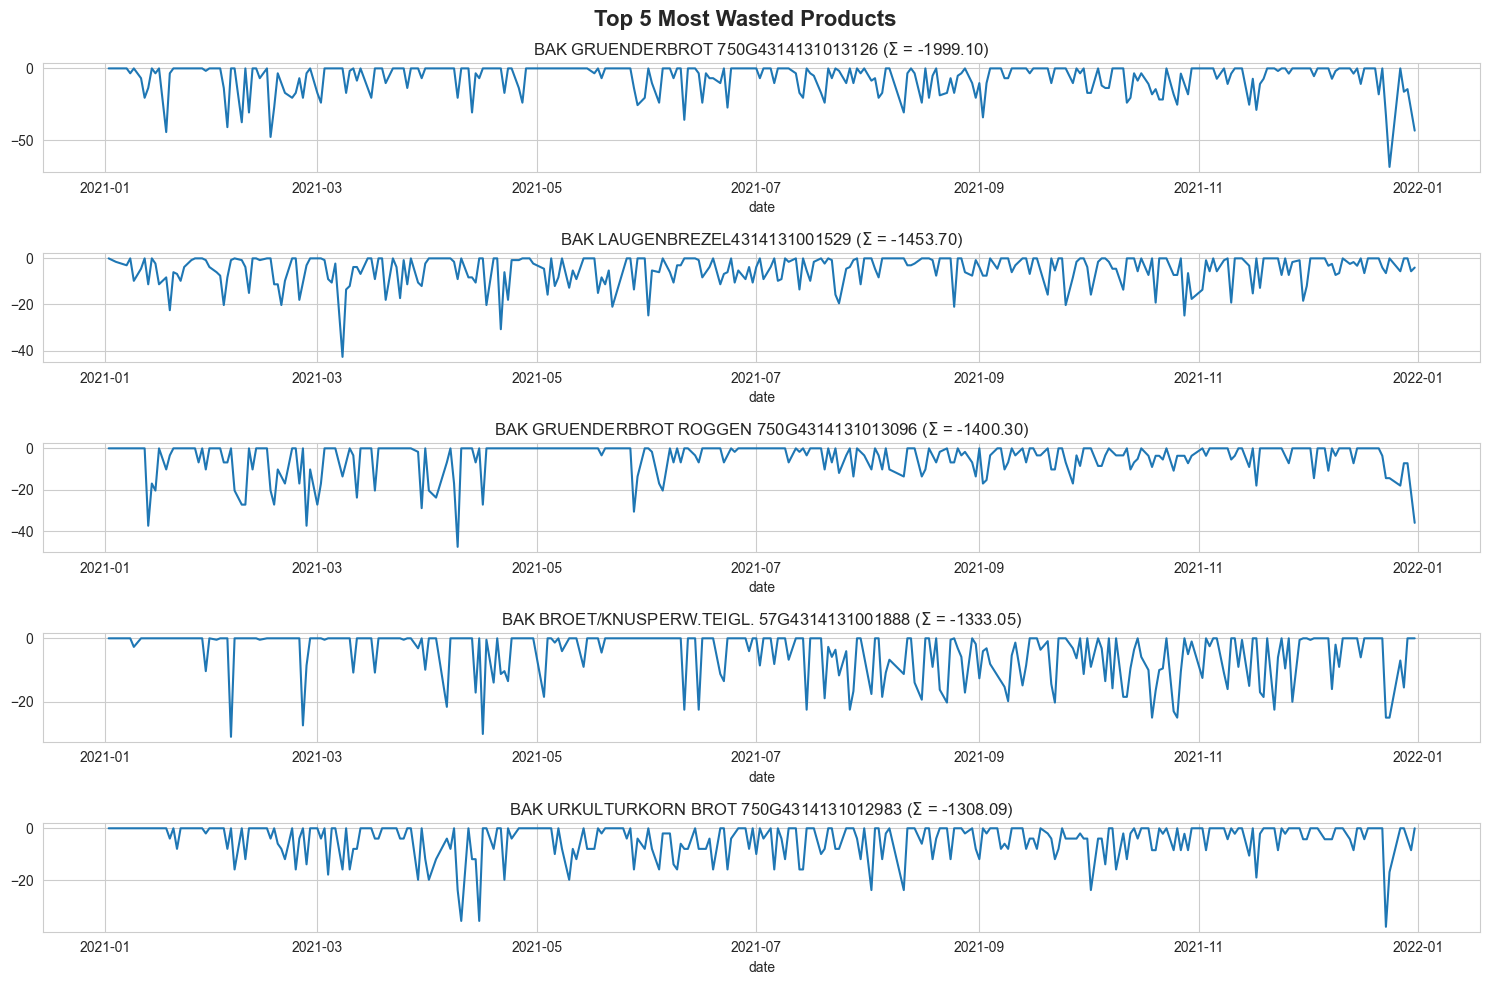

In [25]:
fig, axes = plt.subplots(nrows=K, ncols=1, figsize=(15, K*2))
fig.suptitle(f"Top {K} Most Wasted Products", fontweight="bold", size=16)
for ax, col in zip(axes.flatten(), top_k_foodwasting_products.keys()):
    # Set title and also get sum of wasted revenue over the time frame
    ax.set_title(f"{col} ($\Sigma$ = {top_k_foodwasting_products[col]:.2f})", size=12)
    sns.lineplot(data=df, x="date", y=col, ax=ax)
    # Hide y-axis labels
    ax.yaxis.label.set_visible(False)
fig.tight_layout()
plt.show()

# Modelling

In [37]:
# Sample dataframe
top_foodwasting_product_name:str = top_k_foodwasting_products.keys()[1]
# Preview one sample
gruenderbrot_df = df[[top_foodwasting_product_name]]
gruenderbrot_df.head(5)

,BAK LAUGENBREZEL4314131001529
date,
2021-01-02,0.00
2021-01-04,-1.50
2021-01-07,-3.00
2021-01-08,0.00
2021-01-09,-9.75


## Preprocessing

In [38]:
def train_test_split(df: pd.DataFrame, last_k_percent: float = 0.1):

    # Get total number of samples
    N = len(df)
    # Get last k percent as absolute value
    k = int(N * last_k_percent)

    # Get first N-k values, e.g. first 250 values
    X_train = df.iloc[:(N-k), :]
    # Get last k values, e.g. last 50 values
    X_test = df.iloc[-k:, :]

    return X_train, X_test

train_df, test_df = train_test_split(gruenderbrot_df, last_k_percent=0.1)

In [39]:
train_df.head(5)

,BAK LAUGENBREZEL4314131001529
date,
2021-01-02,0.00
2021-01-04,-1.50
2021-01-07,-3.00
2021-01-08,0.00
2021-01-09,-9.75


In [40]:
def create_time_feature(df):
    df = df.copy()
    df['dayofmonth'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    return df

train_df = create_time_feature(train_df)
test_df = create_time_feature(test_df)
train_df

,BAK LAUGENBREZEL4314131001529,dayofmonth,dayofweek,quarter,month,year,dayofyear
date,,,,,,,
2021-01-02,0.00,2,5,1,1,2021,2
2021-01-04,-1.50,4,0,1,1,2021,4
2021-01-07,-3.00,7,3,1,1,2021,7
2021-01-08,0.00,8,4,1,1,2021,8
2021-01-09,-9.75,9,5,1,1,2021,9
...,...,...,...,...,...,...,...
2021-11-20,0.00,20,5,4,11,2021,324
2021-11-22,0.00,22,0,4,11,2021,326
2021-11-23,0.00,23,1,4,11,2021,327


In [41]:
def get_features_and_labels(train_df, test_df) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    X_train = train_df.drop(top_foodwasting_product_name, axis =1)
    y_train = pd.DataFrame(train_df[top_foodwasting_product_name])

    X_test = test_df.drop(top_foodwasting_product_name, axis =1)
    y_test = pd.DataFrame(test_df[top_foodwasting_product_name])

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = get_features_and_labels(train_df, test_df)

## Fit Model

In [42]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train, verbose = False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [43]:
def make_prediction(X_test, regressor, verbosity: int = 1) -> pd.DataFrame:
    if verbosity > 0:
        print("Making predictions ...")

    # Make prediction
    y_pred = regressor.predict(X_test)
    # Convert to dataframe with index / dates from input features X_test
    y_pred = pd.DataFrame(y_pred, index=X_test.index, columns=[top_foodwasting_product_name])
    return y_pred

# Get y_pred
y_pred: pd.DataFrame = make_prediction(X_test, regressor=reg)
# Evaluate
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
print(f"MSE: {mse:.2f}")

Making predictions ...
MSE: 23.95


In [44]:
def concat_data_with_prediction(y_train: pd.DataFrame, y_pred: pd.DataFrame) -> pd.DataFrame:
    y_train["flag"] = "train"
    y_pred["flag"] = "test"

    df_concat = pd.concat([y_train, y_pred], axis=0)
    return df_concat

df_concat = concat_data_with_prediction(y_train=y_train, y_pred=y_pred)

,BAK LAUGENBREZEL4314131001529,flag
date,,
2021-01-02,0.000000,train
2021-01-04,-1.500000,train
2021-01-07,-3.000000,train
2021-01-08,0.000000,train
2021-01-09,-9.750000,train
...,...,...
2021-12-27,-3.053549,test
2021-12-28,-12.382607,test
2021-12-29,-1.562551,test


## Visualize Model

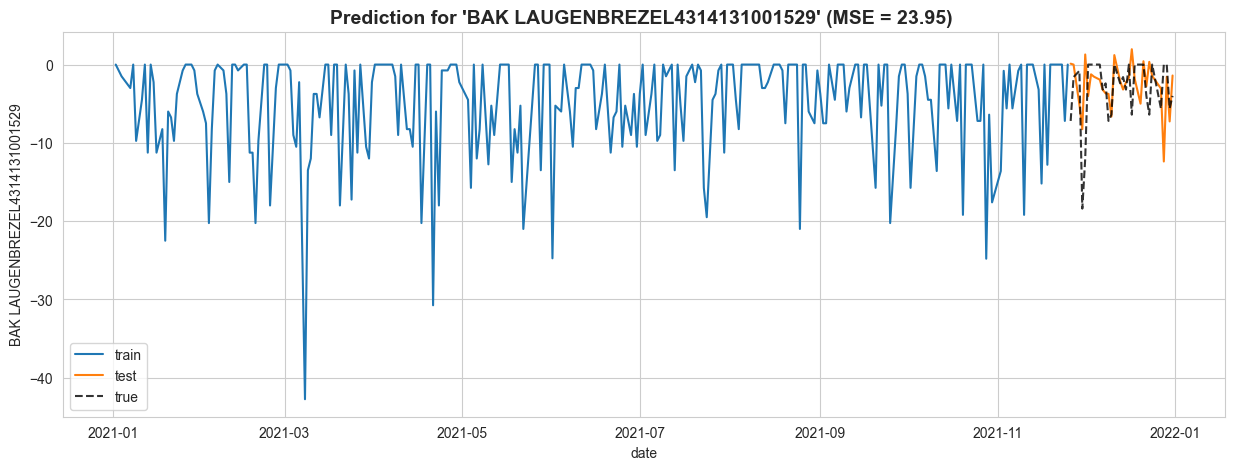

In [52]:
def visualize_predictions(df_concat, test_df) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax.set_title(f"Prediction for '{top_foodwasting_product_name}' (MSE = {mse:.2f}) ", fontweight="bold", size=14)
    sns.lineplot(data=df_concat, x="date", y=top_foodwasting_product_name, hue="flag", ax=ax)
    sns.lineplot(data=test_df, x="date", y=top_foodwasting_product_name, color="black", ax=ax, label="true", alpha=0.8, linestyle="--")
    plt.show()

visualize_predictions(df_concat, test_df)